In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

     |████████████████████████████████| 79.9MB 197kB/s 
     |████████████████████████████████| 61kB 19.7MB/s 
     |████████████████████████████████| 3.0MB 37.8MB/s 
     |████████████████████████████████| 419kB 44.5MB/s 
2.0.0-alpha0


In [0]:
dataset_path = keras.utils.get_file('auto-mpg.data', "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [0]:
# Import using pandas
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, 
                          names=column_names,
                          na_values="?", 
                          comment='\t',
                          sep=" ", 
                          skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
# Origin column is categorical. So convert that to a one-hot
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
# Split the datainto train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

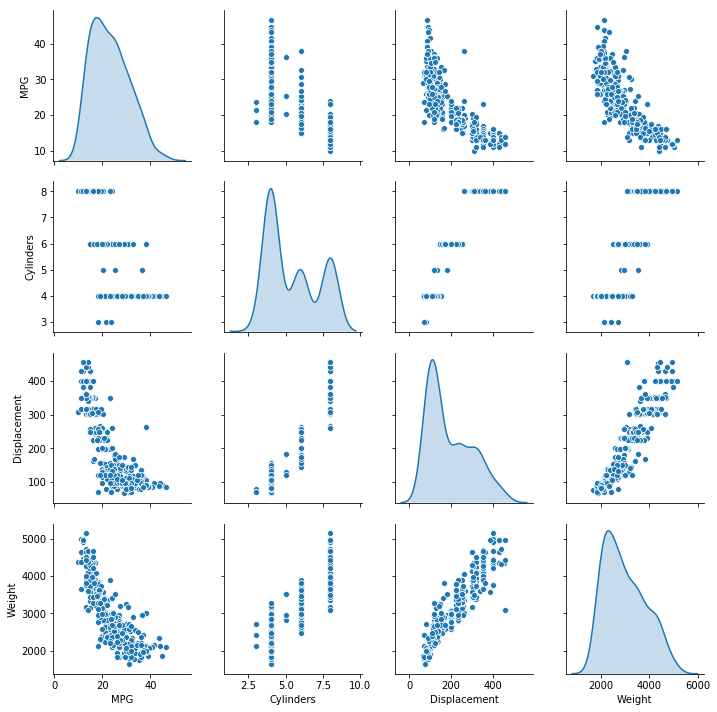

In [0]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],
             diag_kind='kde')

In [0]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
# Separate the target value, or "label", from the features.
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
# normalize data
def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

In [0]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu',
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer = optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [0]:
model = build_model()

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Now try out the model. 
# Take a batch of 10 examples from the training data and call model.
# predict on it.

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.2446891 ],
       [ 0.3725648 ],
       [-0.4329399 ],
       [ 0.5022509 ],
       [-0.15619302],
       [ 0.23884928],
       [-0.12356293],
       [ 0.25378183],
       [ 0.13929391],
       [-0.06907749]], dtype=float32)

In [0]:
# Train the model for 1000 epochs, 
# and record the training and validation accuracy in the history object.

# Display training progress by printing a single dot for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
        
EPOCHS = 1000

history = model.fit(
        x=normed_train_data,
        y=train_labels,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=0,
        callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.798019,1.056494,2.798019,9.366731,2.293865,9.366732,995
996,2.878626,1.097802,2.878627,9.644781,2.331902,9.644781,996
997,2.968734,1.067346,2.968734,10.023117,2.379027,10.023118,997
998,2.992930,1.132235,2.992930,9.390039,2.306290,9.390039,998
999,2.925705,1.104980,2.925705,9.857623,2.355183,9.857623,999


In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()

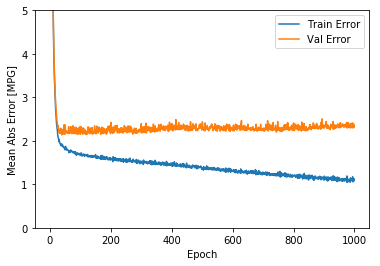

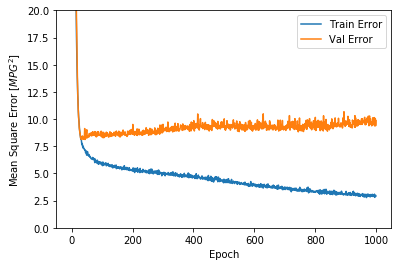

In [0]:
plot_history(history)

In [0]:
# Let's update the model.fit call to automatically stop training when the validation score doesn't improve.
# EarlyStopping callback.
# If a set amount of epochs elapses without showing improvement, then automatically stop the training.

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])


................................................

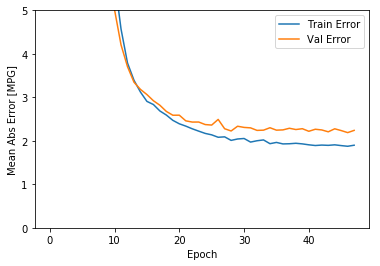

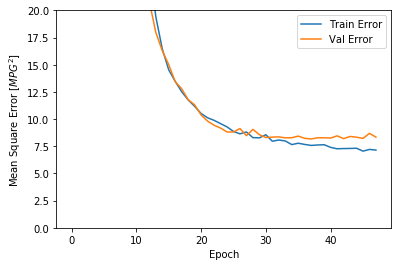

In [0]:
plot_history(history)

In [0]:
# Let's see how well the model generalizes by using the test set
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} MPG'.format(mae))

Testing set Mean Abs Error:  1.84 MPG


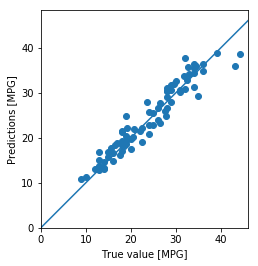

In [0]:
# predict values

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True value [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal') # Set equal scaling (i.e., make circles circular) by changing axis limits.
plt.axis('square') # xmax-xmin = ymax-ymin
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

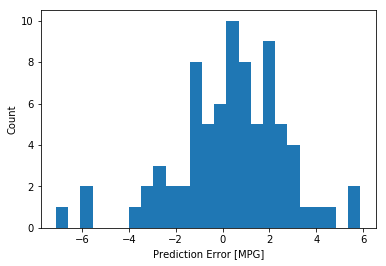

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [0]:
# It's not quite gaussian, but we might expect that because the number of samples is very small.
# https://www.tensorflow.org/alpha/tutorials/keras/basic_regression